<a href="https://colab.research.google.com/github/dhiakhouja/E-commerce---Users-of-a-French-C2C-fashion-store-/blob/main/bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('darkgrid')

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

#Exploratory Analysis
##Read the CSV and Perform Basic Data Cleaning

In [2]:
from google.colab import files
uploaded = files.upload()

Saving bank_churn.csv to bank_churn.csv


In [3]:

df=pd.read_csv("bank_churn.csv")

In [4]:
df

,id_client,Surname,Pays,Sexe,Age,Score_Credit,Avoirs,Revenus_annuels,Carte_Platine,Nb_Contrats_Vie,Client_Patrimonial,Anciennete,Resiliation
0,30379,Bailey,France,Male,34.0,684.0,10000.00,"140515,14",1.0,2.0,1.0,28.0,0
1,9717,Chiu,Germany,Female,54.0,794.0,161801.68,"394309,32",1.0,1.0,1.0,4.0,0
2,10137,Veltri,France,NaN,37.0,655.0,233705.68,"31022,26",1.0,2.0,0.0,22.0,0
3,4293,Stewart,France,Female,40.0,787.0,10000.00,"178303,96",1.0,2.0,NaN,19.0,0
4,30585,Davis,France,Male,37.0,822.0,221126.00,"375249,86",1.0,1.0,0.0,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39536,25670,Yang,France,Female,42.0,850.0,236622.22,"406387,5",1.0,1.0,1.0,28.0,0
39537,29316,De Luca,Spain,Male,33.0,779.0,10000.00,NaN,1.0,2.0,0.0,10.0,0
39538,2890,Costa,Germany,Male,37.0,NaN,246101.58,"114602,3",0.0,1.0,1.0,19.0,0
39539,18763,Pirogova,France,Female,27.0,739.0,10000.00,"125144,76",1.0,1.0,NaN,19.0,0


In [5]:
print(f"Dataframe dimensions: {df.shape}")
df.head()

Dataframe dimensions: (39541, 13)


,id_client,Surname,Pays,Sexe,Age,Score_Credit,Avoirs,Revenus_annuels,Carte_Platine,Nb_Contrats_Vie,Client_Patrimonial,Anciennete,Resiliation
0,30379,Bailey,France,Male,34.0,684.0,10000.00,"140515,14",1.0,2.0,1.0,28.0,0
1,9717,Chiu,Germany,Female,54.0,794.0,161801.68,"394309,32",1.0,1.0,1.0,4.0,0
2,10137,Veltri,France,NaN,37.0,655.0,233705.68,"31022,26",1.0,2.0,0.0,22.0,0
3,4293,Stewart,France,Female,40.0,787.0,10000.00,"178303,96",1.0,2.0,NaN,19.0,0
4,30585,Davis,France,Male,37.0,822.0,221126.00,"375249,86",1.0,1.0,0.0,10.0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39541 entries, 0 to 39540
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_client           39541 non-null  int64  
 1   Surname             39541 non-null  object 
 2   Pays                37636 non-null  object 
 3   Sexe                37484 non-null  object 
 4   Age                 37684 non-null  float64
 5   Score_Credit        37675 non-null  float64
 6   Avoirs              37575 non-null  float64
 7   Revenus_annuels     37673 non-null  object 
 8   Carte_Platine       37632 non-null  float64
 9   Nb_Contrats_Vie     37574 non-null  float64
 10  Client_Patrimonial  37648 non-null  float64
 11  Anciennete          37633 non-null  float64
 12  Resiliation         39541 non-null  int64  
dtypes: float64(7), int64(2), object(4)
memory usage: 3.9+ MB


In [7]:
# List number of unique customer IDs
df.id_client.nunique()

33889

In [8]:
df.id_client.duplicated().sum()

5652

### suppression des doublons

In [9]:
df.drop_duplicates(keep = 'first', inplace=True)

In [10]:
df.duplicated().sum()

0

In [11]:
df.nunique()

id_client             33889
Surname                2907
Pays                      3
Sexe                      2
Age                      70
Score_Credit            455
Avoirs                 5972
Revenus_annuels        9380
Carte_Platine             2
Nb_Contrats_Vie           4
Client_Patrimonial        2
Anciennete               11
Resiliation               2
dtype: int64

In [12]:
# Affichage des valeurs nulles
df.isnull().sum()

id_client                0
Surname                  0
Pays                  1627
Sexe                  1775
Age                   1583
Score_Credit          1625
Avoirs                1678
Revenus_annuels       1599
Carte_Platine         1641
Nb_Contrats_Vie       1690
Client_Patrimonial    1621
Anciennete            1626
Resiliation              0
dtype: int64

##### D'après ce qui précède, nous n'exigerons pas les 2 premiers attributs car ils sont des données personnelles.

In [13]:
df = df.drop([ "id_client", "Surname"], axis = 1)
df.head()

,Pays,Sexe,Age,Score_Credit,Avoirs,Revenus_annuels,Carte_Platine,Nb_Contrats_Vie,Client_Patrimonial,Anciennete,Resiliation
0,France,Male,34.0,684.0,10000.00,"140515,14",1.0,2.0,1.0,28.0,0
1,Germany,Female,54.0,794.0,161801.68,"394309,32",1.0,1.0,1.0,4.0,0
2,France,NaN,37.0,655.0,233705.68,"31022,26",1.0,2.0,0.0,22.0,0
3,France,Female,40.0,787.0,10000.00,"178303,96",1.0,2.0,NaN,19.0,0
4,France,Male,37.0,822.0,221126.00,"375249,86",1.0,1.0,0.0,10.0,0


## Analyse exploratoire des données

Notre principal intérêt est de comprendre comment le lien entre les diferents attribus et le statut « Resiliation ».

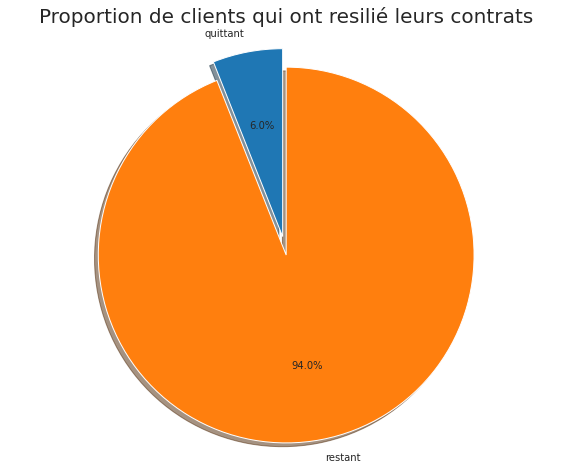

In [14]:
labels = 'quittant', 'restant'
sizes = [df.Resiliation[df['Resiliation']==1].count(), df.Resiliation[df['Resiliation']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion de clients qui ont resilié leurs contrats", size = 20)
plt.show()


Donc, environ 6% des clients ont resilié. Notre modèle de référence pourrait donc consister à prédire que 6 % des clients désabonnés. Étant donné que 6 % est un petit nombre, nous devons nous assurer que le modèle choisi prédit avec une grande précision ces 6 %, car il est dans l'intérêt de la banque d'identifier et de conserver ce groupe plutôt que de prédire avec précision les clients retenus.

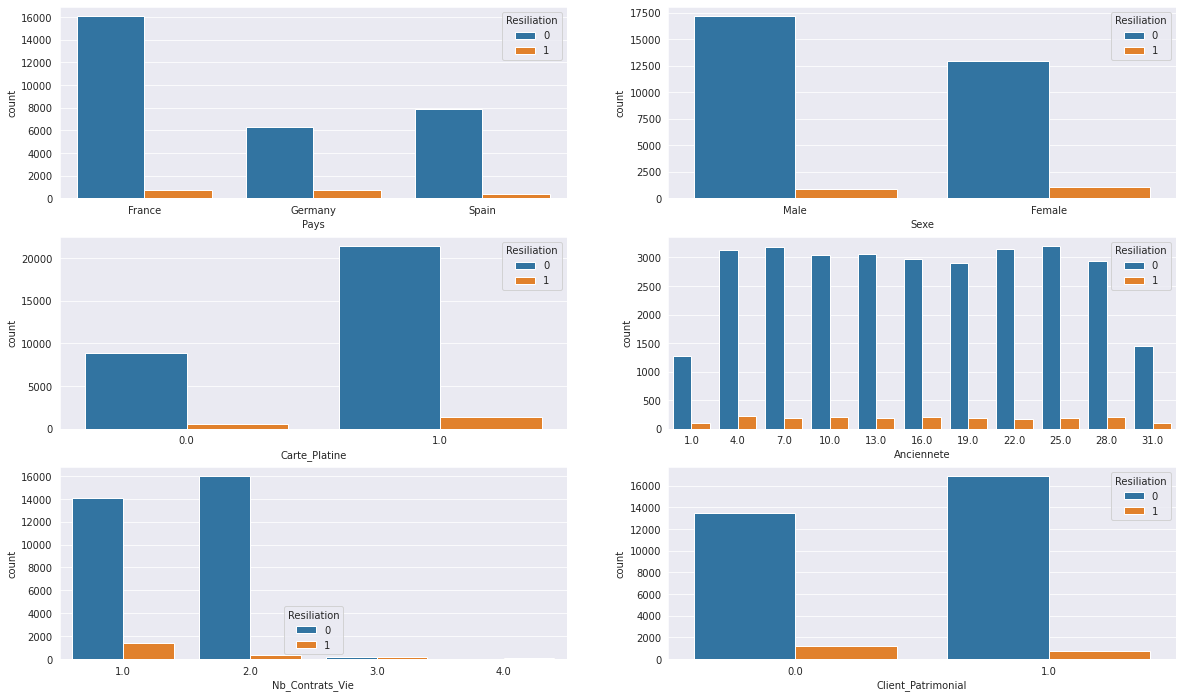

In [38]:
    # Nous allons étudier la relation entre 'Resiliation' et les variables categorielles 
    fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
    sns.countplot(x='Pays', hue = 'Resiliation',data = df, ax=axarr[0][0])
    sns.countplot(x='Sexe', hue = 'Resiliation',data = df, ax=axarr[0][1])
    sns.countplot(x='Carte_Platine', hue = 'Resiliation',data = df, ax=axarr[1][0])
    sns.countplot(x='Anciennete', hue = 'Resiliation',data = df, ax=axarr[1][1])
    sns.countplot(x='Nb_Contrats_Vie', hue = 'Resiliation',data = df, ax=axarr[2][0])
    sns.countplot(x='Client_Patrimonial', hue = 'Resiliation',data = df, ax=axarr[2][1])
    
   




*   La majorité des clients sont des Français. Cependant, la proportion de clients désabonnés est inversement liée à la population de clients faisant allusion au fait que la banque a éventuellement un problème (peut-être pas assez de ressources de service client allouées) dans les zones où elle a moins de clients.
*   La proportion de clients féminins qui ont resilié est également supérieure à celle des clients masculins.
*  Il est intéressant de noter que la majorité des clients qui ont resilié sont ceux qui ont des cartes de crédit. Étant donné que la majorité des clients ont des cartes de crédit

*   la majorité des clients qui ont resilié sont ceux qui ont des  2 contrats de vie




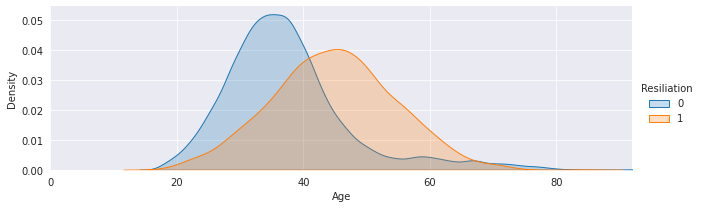

In [17]:
facet = sns.FacetGrid(df, hue="Resiliation",aspect=3)
facet.map(sns.kdeplot,"Age",shade= True)
facet.set(xlim=(0, df["Age"].max()))
facet.add_legend()

plt.show()

La majorité des clients qui ont resilié leurs Age est environ 45

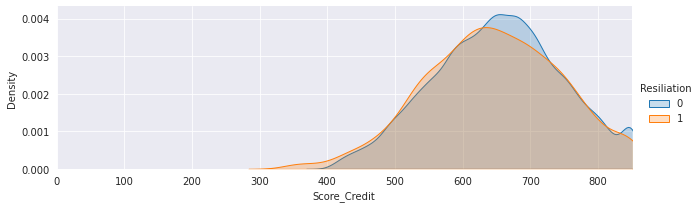

In [21]:
facet = sns.FacetGrid(df, hue="Resiliation",aspect=3)
facet.map(sns.kdeplot,"Score_Credit",shade= True)
facet.set(xlim=(0, df["Score_Credit"].max()))
facet.add_legend()

plt.show()


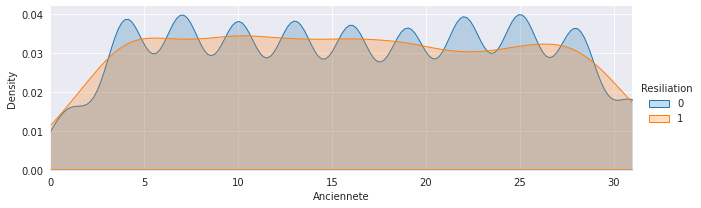

In [36]:
facet = sns.FacetGrid(df, hue="Resiliation",aspect=3)
facet.map(sns.kdeplot,"Anciennete",shade= True)
facet.set(xlim=(0, df["Anciennete"].max()))
facet.add_legend()

plt.show()

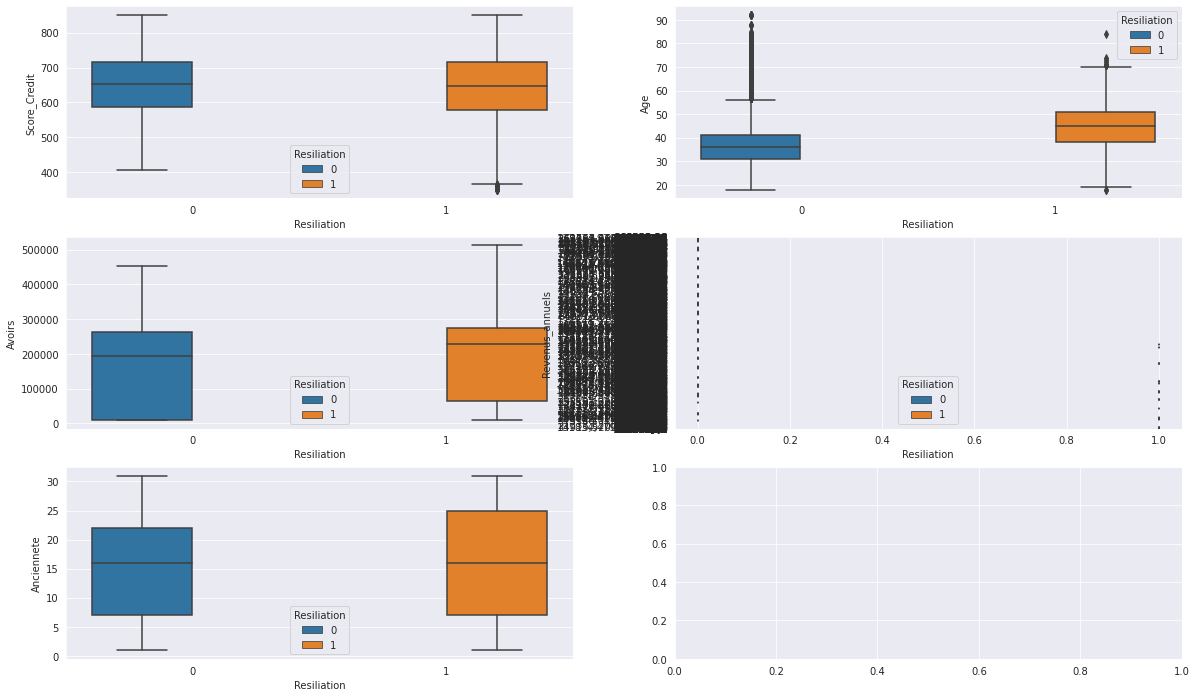

In [34]:
    fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
    sns.boxplot(y='Score_Credit',x = 'Resiliation', hue = 'Resiliation',data = df, ax=axarr[0][0])
    sns.boxplot(y='Age',x = 'Resiliation', hue = 'Resiliation',data = df , ax=axarr[0][1])
    sns.boxplot(y='Avoirs',x = 'Resiliation', hue = 'Resiliation',data = df, ax=axarr[1][0])
    sns.boxplot(y='Revenus_annuels',x = 'Resiliation', hue = 'Resiliation',data = df, ax=axarr[1][1])
    sns.boxplot(y='Anciennete',x = 'Resiliation', hue = 'Resiliation',data = df, ax=axarr[2][0])
    



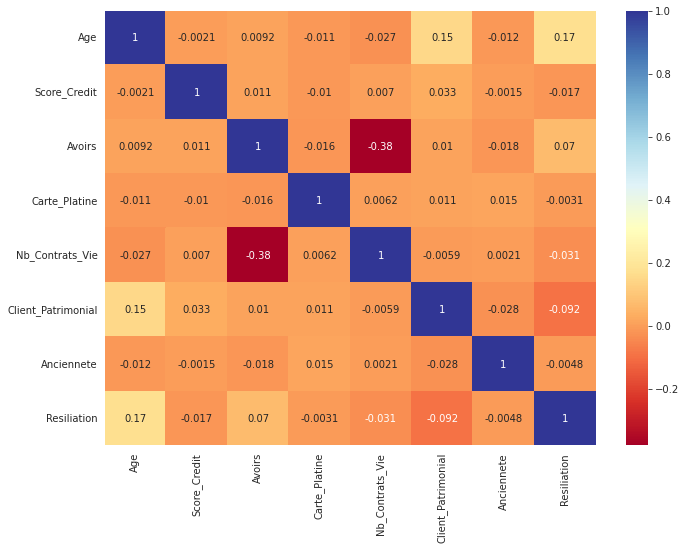

In [39]:
plt.subplots(figsize=(11,8))
sns.heatmap(df.corr(), annot=True, cmap="RdYlBu")
plt.show()